In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from scipy.stats import skew

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor

# metrics & utils
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression

In [2]:
df_train = pd.read_csv('train.csv')
df_submit = pd.read_csv('test.csv')
all_data = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'],
                     df_submit.loc[:,'MSSubClass':'SaleCondition']))

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
# Test dropping some features to improve RMSE
all_data = all_data.drop(['PoolArea', 'PoolQC','Alley', 'MiscFeature', 'MiscVal', 'Fence'], axis=1)

In [5]:
#log transform the target:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [6]:
# Convert all categorical data to binary representation
all_data = pd.get_dummies(all_data)
# Fill all the NaN values with the mean value of that col
all_data = all_data.fillna(all_data.mean())

In [7]:
#creating matrices for sklearn:
X_train = all_data[:df_train.shape[0]]
X_test = all_data[df_train.shape[0]:]
y = df_train.SalePrice

In [8]:
# # Create a test, train and submission X and y
# X = df_train.loc[:,'MSSubClass':'SaleCondition']
# y = df_train.SalePrice
# X_submit = df_submit
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [9]:
# Create a function which calculates Root Mean Squared Error (RMSE)
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', 
                                   cv = 5))
    return rmse

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Columns: 273 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(23), int64(11), uint8(239)
memory usage: 740.0 KB


In [11]:
linreg = LinearRegression()
linreg.fit(X_train, y)
rmse_cv(linreg).mean()

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.13911244296657951

In [21]:
lasso = LassoCV(alphas = [1, 0.1, 0.002, 0.001, 0.0008, 0.0005], verbose=True)
lasso.fit(X_train, y)
rmse_cv(lasso).mean()

..................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
..................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
..................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
..................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
..................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
..................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


0.12287581949305711

In [13]:
y_pred_test = np.expm1(lasso.predict(X_test))

In [14]:
submission = pd.DataFrame({
        'Id': df_submit['Id'],
        'SalePrice': y_pred_test
    })
submission.to_csv('submission_lasso.csv', index=False)

In [15]:
lasso_coef = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(lasso_coef != 0)) + " variables and eliminated the other " +  str(sum(lasso_coef == 0)) + " variables")

Lasso picked 108 variables and eliminated the other 165 variables


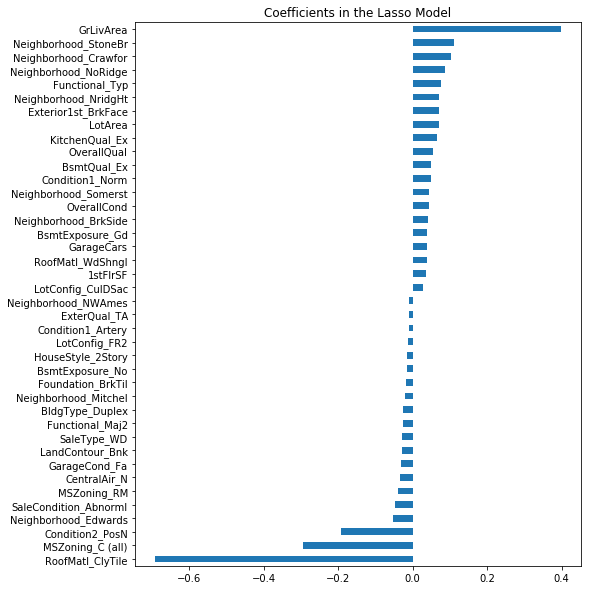

In [16]:
imp_coef = pd.concat([lasso_coef.sort_values().head(20),
                     lasso_coef.sort_values().tail(20)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

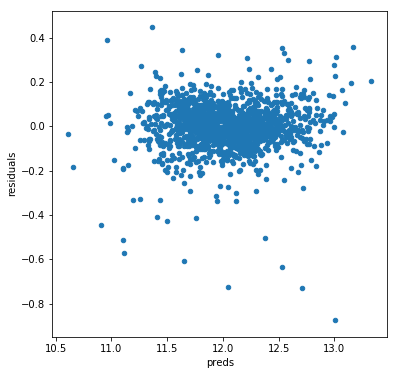

In [17]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")